In [54]:
import pandas as pd
import numpy as np
from keras.layers import Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import shutil
import joblib
from tensorflow.keras import layers,Sequential

In [2]:
image_size=255 # pixel size
channel=3 # RGB

In [3]:
%pwd

'C:\\ML Projects\\Leaf-Desease-Detector-End2End\\notebook'

In [ ]:
# os.path.join()

In [4]:
data=tf.keras.preprocessing.image_dataset_from_directory(directory='potato_leaf_desease_dataset',
                                                        batch_size=35,
                                                         image_size=(255,255),
                                                         seed=123)

Found 1203 files belonging to 3 classes.


In [5]:
classes=data.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
classes[0]

'Potato___Early_blight'

In [7]:
data.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
for image_batch,image_labels in data.take(1):
    print(image_batch.shape)
    print(image_labels.numpy())

(35, 255, 255, 3)
[2 0 0 1 2 0 2 2 1 1 2 1 0 2 0 1 2 2 0 0 0 1 0 0 1 1 1 2 1 1 1 0 1 2 1]


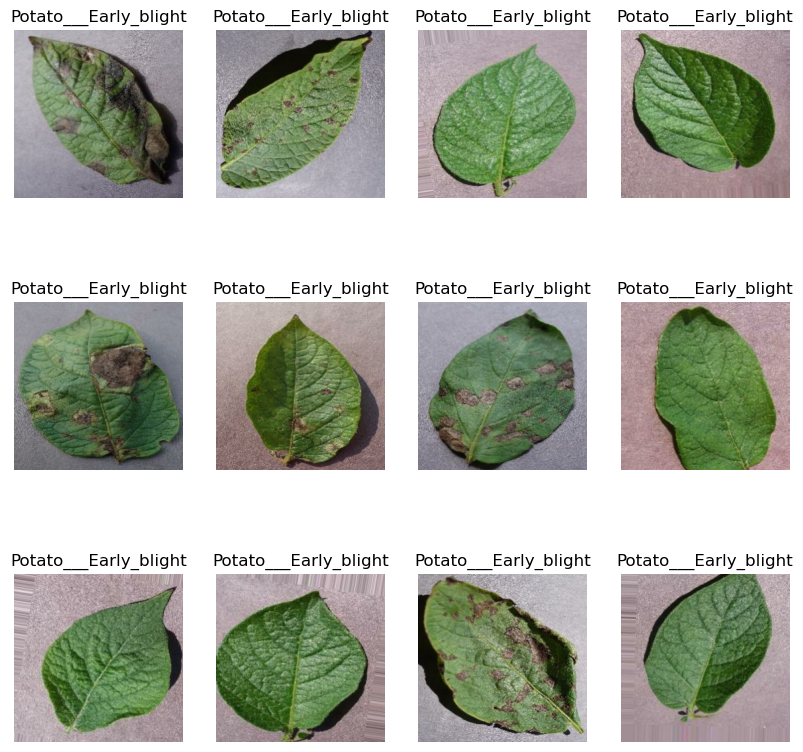

In [9]:
plt.figure(figsize=(10,10))
for image_batch,image_label in data.take(1):
    for i in range(12):        
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[image_label[1]])
        plt.axis('off')

In [10]:
len(data)

35

In [11]:
train_size=0.8
len(data)*train_size

28.0

In [18]:
train=data.take(28)

In [19]:
test=data.skip(28)

In [20]:
len(test)

7

In [21]:
val_size=0.1
val=len(data)*val_size
val

3.5

In [22]:
val=test.take(6)
len(val)

6

In [23]:
test=test.skip(6)
len(test)

1

In [24]:
train_data=train.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_data=test.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_data=val.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [25]:
resize_scale=Sequential([
    layers.experimental.preprocessing.Resizing(255,255),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [26]:
rotation_aug=Sequential([
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [27]:
model=tf.keras.models.Sequential([
    resize_scale,
    rotation_aug,
    layers.Conv2D(30,kernel_size=(3,3),activation='relu',input_dim=(255,255,3)),
    layers.MaxPool2D(),
    layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(80,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(62,'relu'),
    layers.Dense(3,activation='softmax')
    
])

model.build(input_shape=(32,255,255,3))

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 30)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 50)        13550     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 50)          0         
 g2D)                                                 

In [29]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [30]:
model.fit(train_data,batch_size=32,epochs=10,validation_data=val_data,verbose=1)

Epoch 1/10
28/28 [==============================] - 426s 14s/step - loss: 1.2487 - accuracy: 0.3929 - val_loss: 0.9653 - val_accuracy: 0.4238
Epoch 2/10
28/28 [==============================] - 309s 11s/step - loss: 0.9293 - accuracy: 0.5541 - val_loss: 0.8877 - val_accuracy: 0.5286
Epoch 3/10
28/28 [==============================] - 196s 7s/step - loss: 0.6010 - accuracy: 0.7245 - val_loss: 0.4461 - val_accuracy: 0.7952
Epoch 4/10
28/28 [==============================] - 211s 7s/step - loss: 0.4579 - accuracy: 0.7888 - val_loss: 0.3965 - val_accuracy: 0.8333
Epoch 5/10
28/28 [==============================] - 180s 6s/step - loss: 0.3402 - accuracy: 0.8571 - val_loss: 0.3465 - val_accuracy: 0.8619
Epoch 6/10
28/28 [==============================] - 169s 6s/step - loss: 0.2406 - accuracy: 0.9041 - val_loss: 0.2031 - val_accuracy: 0.9190
Epoch 7/10
28/28 [==============================] - 180s 6s/step - loss: 0.2677 - accuracy: 0.8837 - val_loss: 0.1970 - val_accuracy: 0.9381
Epoch 8/10


In [31]:
loss=model.history.history['loss']

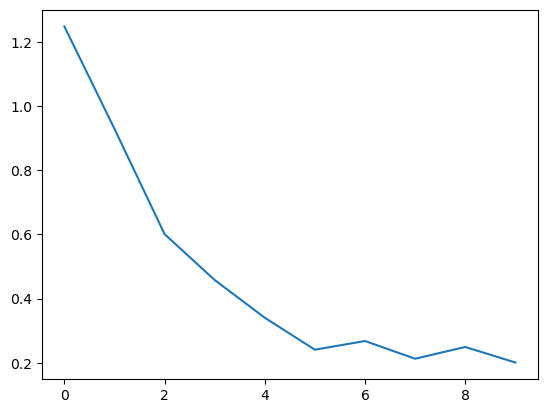

In [32]:
plt.plot(loss)

In [33]:
model.evaluate(test_data)

1/1 [==============================] - 5s 5s/step - loss: 0.1121 - accuracy: 0.9231


[0.11207817494869232, 0.9230769276618958]

In [34]:
for batch,label in test_data.take(1):
    print(batch.shape)
    print(label.numpy())

(13, 255, 255, 3)
[2 2 2 1 2 0 1 1 2 1 0 1 2]


In [35]:
for batch,label in val_data.take(1):
    print(batch.shape)
    print(label.numpy())

(35, 255, 255, 3)
[2 2 2 1 1 1 0 2 1 1 2 0 0 2 2 0 1 1 1 2 2 1 1 0 2 2 1 0 0 2 2 1 2 2 1]


first image to predict
actual label: Potato___healthy
1/1 [==============================] - 2s 2s/step
predicted label: Potato___healthy


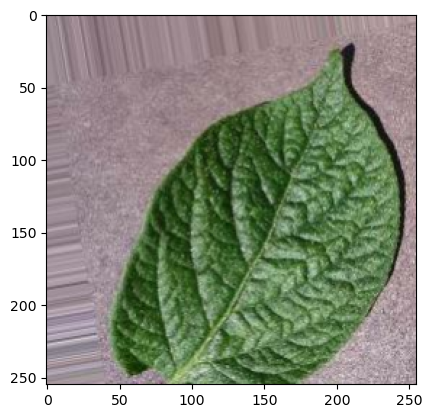

In [36]:
for image_batch,image_label in test_data.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=image_label[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', classes[first_label])
    
    prediction=model.predict(image_batch)
    print('predicted label:',classes[np.argmax(prediction[0])])
#     print('confidence:',np.argmax(prediction[0]))

In [49]:
def prediction(image):
    img=load_img(image)
    prepro=tf.keras.preprocessing.image.img_to_array(img)
    dim=tf.expand_dims(prepro,0)
    
    pred=model.predict(dim)
    
    predicted_classes=classes[np.argmax(pred[0])]
    confidance=round(100*(np.max(pred[0])),2)
    return predicted_classes, confidance

1/1 [==============================] - 0s 219ms/step


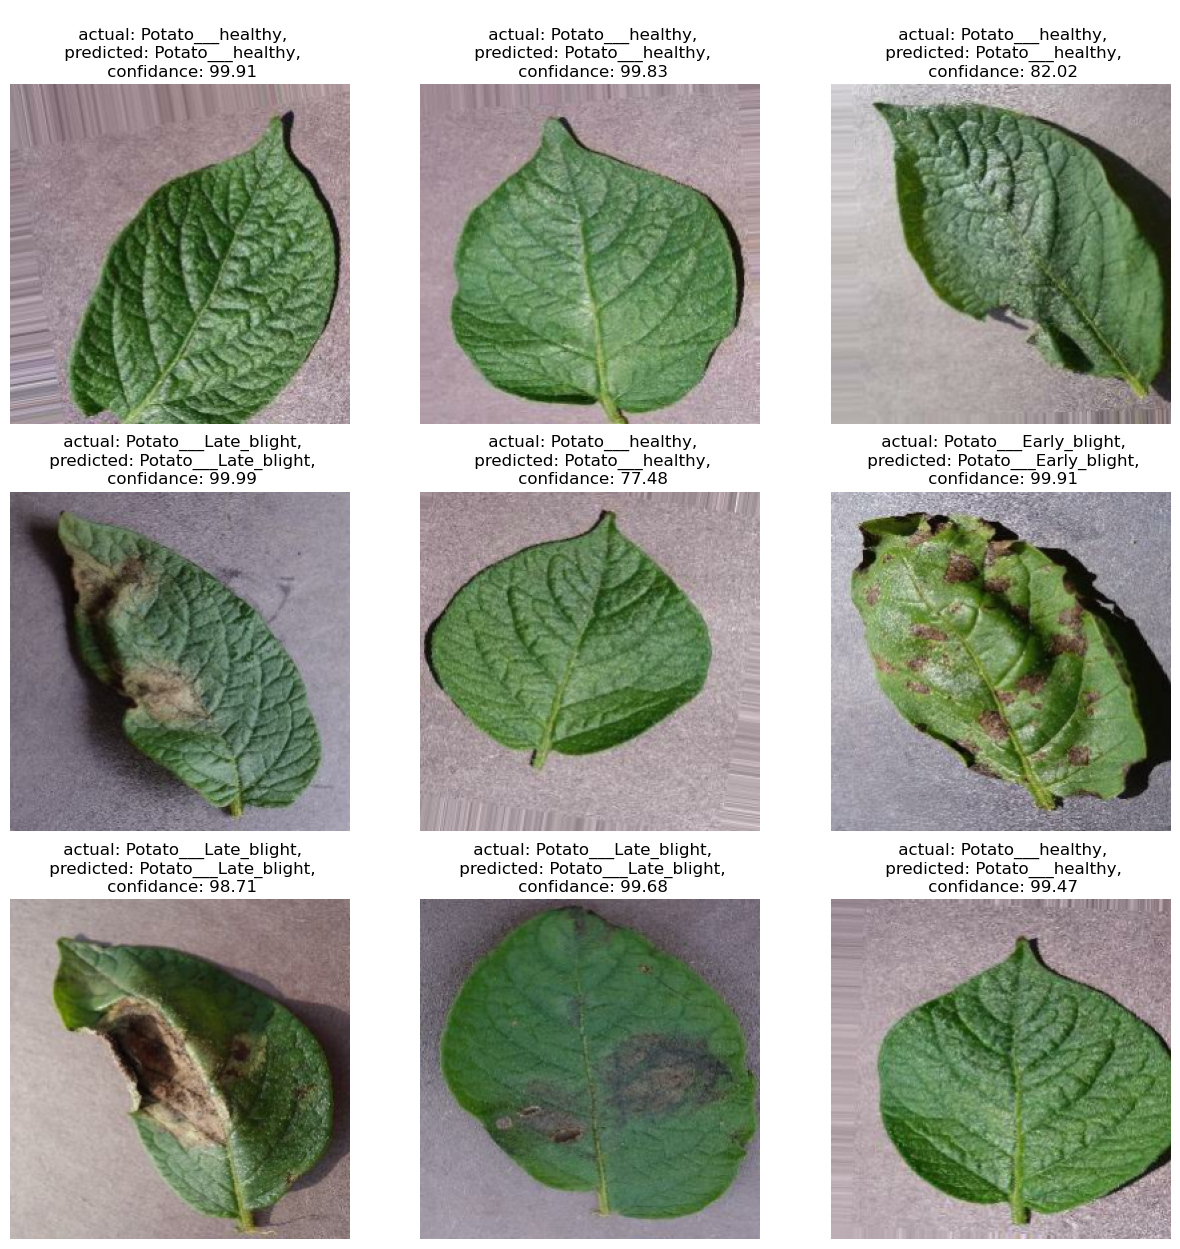

In [38]:
plt.figure(figsize=(15,15))
for image_batch,image_label in test_data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        actual_class=classes[image_label[i]]
        
        pred,confidance=prediction(model,image_batch[i].numpy())
        plt.title(f'\n actual: {actual_class},\n predicted: {pred},\n confidance: {confidance}')
        
        plt.axis('off')

In [39]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [40]:
late_blight=load_img('late_blight.jpg')

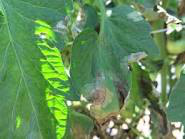

In [41]:
late_blight

In [43]:
prediction(model,late_blight)

1/1 [==============================] - 1s 624ms/step


('Potato___healthy', 99.9)

In [44]:
late_blight_2=load_img('late blight.jpg')

In [45]:
prediction(model,late_blight_2)

1/1 [==============================] - 0s 133ms/step


('Potato___Late_blight', 71.34)

In [50]:
prediction('early_blight_leaf.jpg')

1/1 [==============================] - 0s 217ms/step


('Potato___Early_blight', 97.14)

In [51]:
prediction('early blight 2.jpg')

1/1 [==============================] - 0s 133ms/step


('Potato___Early_blight', 99.99)

In [52]:
prediction('download.jpg')

1/1 [==============================] - 0s 249ms/step


('Potato___Early_blight', 99.97)

In [53]:
prediction('healthy_1.jpg')

1/1 [==============================] - 0s 116ms/step


('Potato___healthy', 100.0)

In [57]:
joblib.dump(model,'model.h5')

['model.h5']